In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score, roc_curve,auc
from math import log
from numpy import mean
import io
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import time
import eli5

2023-02-12 11:05:21.199828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# https://archive.ics.uci.edu/ml/datasets/Heart+Disease
df = pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
def check_distribution(df):
    for column in df.columns:
        print(f"Skewness for the column is: {column}", df[column].skew())
        if  df[column].skew()>0:
            print("Distribution is right skewed.")
        elif  df[column].skew()<0:
            print("Distribution is left skewed.")
        else:
            print("Normally distributed.")

        sns.displot(df[column], kde = True)
    plt.show()

# This function would find correlated features and delete them from the data
def find_and_remove_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    print(f'A feature is correlated if they have a correlation of {threshold}')
    print()
    print('Correlated features are:')
    print()
    removed = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if ( abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                # getting the name of column1
                col1 = corr_matrix.columns[i]
                # getting the name of column2
                col2 = corr_matrix.columns[j] 
                colname = corr_matrix.columns[i] # getting the name of column
                print(f"'{col1}' and '{col2}' are correlated with a correlation value of:  {round(corr_matrix.iloc[i, j],2)}")
                print()
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    removed.append(colname)
                    
    if len(removed)>0:
        
        print("Removed columns are :", str(removed).replace("[",'').replace("]", '').replace("'", ''))
    else:
        print("No column is correlated enough with other column to be removed.")
    return dataset

#This function would return model scores
# We will also be balancing data using SMOTTE here and then finally doing a cross validation after fitting the model

def gridsearchit(reg, grid, X_train, X_test, y_train, y_test):
    grid_ = GridSearchCV(estimator = reg, param_grid = grid, cv = 2, n_jobs=4, verbose = 0, scoring='roc_auc')
    grid_.fit(X_train, y_train)
    print(f"Results from Grid Search: " )
    print(f"\nThe best estimator across ALL searched params for {str(reg).split('(')[0]}\n", grid_.best_estimator_)
    print(f"\nThe best score across ALL searched params for {str(reg).split('(')[0]}", grid_.best_score_)
    print(f"\nThe best parameters across ALL searched params for {str(reg).split('(')[0]}:\n", grid_.best_params_)
    print()
    # Getting the best estimator
    optimized_model = grid_.best_estimator_
    return optimized_model

def cross_entropy(p, q, ets=1e-15):
 return -sum([p[i]*log(q[i]+ets) for i in range(len(p))])

def classifier(clf, X,y ):

    start = time.time()

    # Defining the folds
    kf = StratifiedKFold(n_splits=5)

    fold = 0
    
    # These lists would contain all the scores across 5 folds, we would be taking a mean of them
    roc_train, roc_test,f1_train, f1_test, precision_train, precision_test,recall_train, recall_test,accuracy_train, accuracy_test = [], [], [], [], [],[], [], [], [], []
    loss_train, loss_test = [], []
    for train_index, test_index in kf.split(X, y):

        X_train, y_train, X_test, y_test = X.iloc[train_index], y.iloc[train_index], X.iloc[test_index], y.iloc[test_index]

        # Scaling the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # creating smotes object
        smote = SMOTE()

        # Applying smote to train data
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
        #Fitting the model
        clf.fit(X_train, y_train ) 
        
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        # Calculating Roc score
        roc_train.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))    
        roc_test.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))    
        
        # Calculating fscore, precision & recall 
        f1_train.append(f1_score(y_train, y_train_pred))
        f1_test.append(f1_score(y_test, y_test_pred))
        
        precision_train.append(precision_score(y_train, y_train_pred))
        precision_test.append(precision_score(y_test, y_test_pred))
        
        recall_train.append(recall_score(y_train, y_train_pred))
        recall_test.append(recall_score(y_test, y_test_pred))
        
        #Calculating accuracy
        accuracy_train.append(accuracy_score(y_train,y_train_pred))
        accuracy_test.append(accuracy_score(y_test,y_test_pred))

        loss_train.append(cross_entropy(y_train.values, y_train_pred))
        loss_test.append(cross_entropy(y_test.values, y_test_pred))

        print("Fold: ", fold + 1, ' done')
        fold+=1
    
    mean_acc_train = np.mean(accuracy_train, axis = 0)
    mean_acc_test = np.mean(accuracy_test, axis = 0)
    
    mean_prec_train = np.mean(precision_test, axis = 0)
    mean_prec_test = np.mean(precision_test, axis = 0)
    
    
    mean_rec_train = np.mean(recall_train, axis = 0)
    mean_rec_test = np.mean(recall_test, axis = 0)
    
    mean_f1_train = np.mean(f1_train, axis = 0)
    mean_f1_test = np.mean(f1_test, axis = 0)
    
    mean_roc_train = np.mean(roc_train, axis = 0)
    mean_roc_test = np.mean(roc_test, axis = 0)

    mean_loss_train = np.mean(loss_train, axis = 0)
    mean_loss_test = np.mean(loss_test, axis = 0)
    
    print()
    print("Mean Accuracy on train set is: ", mean_acc_train )
    print("Mean Accuracy on test set is: ", mean_acc_test )
    print()
    print("Mean F score on train set is:", mean_f1_train)
    print("Mean F score on test set is:", mean_f1_test)

    print()
    print("Mean Precision on train set is:", mean_prec_train )
    print("Mean Precision on test set is:", mean_prec_test )
    print()
    print("Mean Recall on train set is:", mean_rec_train )
    print("Mean Recall on test set is:", mean_rec_test )
    print()
    print('Mean Train ROC is:', mean_roc_train )
    print('Mean Test ROC is:', mean_roc_test )

    print('Mean Train loss is:', mean_loss_train )
    print('Mean Test loss is:', mean_loss_test )

    
    
    # displaying confusion matrix
    conf = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf, annot=True, fmt='g'); 
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Confusion Matrix'); 

    
    # Create ROC AUC curve
    fig, [ax1, ax2] = plt.subplots(1, 2,  figsize=(6, 4 ));

    fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
    ax1.plot(fpr, tpr);
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate');
    ax1.set_title('Train ROC-AUC Curve');

    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    ax2.plot(fpr, tpr);
    ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate');
    ax2.set_title('Test ROC-AUC Curve');
    plt.tight_layout(pad=0.3)
    
    fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6, 1,  figsize=(5, 10 ));
    ax1.scatter(["Train Set","Test Set"], [mean_acc_train, mean_acc_test])
    ax1.set_title("Accuracy for train and test sets!")
    ax2.scatter(["Train Set","Test Set"], [mean_prec_train, mean_prec_test])
    ax2.set_title("Precision for train and test sets!")
    plt.tight_layout(pad=0.3)
    ax3.scatter(["Train Set","Test Set"], [mean_rec_train, mean_rec_test])
    ax3.set_title("Recall for train and test sets!")
    ax4.scatter(["Train Set","Test Set"], [mean_roc_train, mean_roc_test])
    ax4.set_title("ROC-AUC for train and test sets!")
    ax5.scatter(["Train Set","Test Set"], [mean_f1_train, mean_f1_test])
    ax5.set_title("F-Score for train and test sets!")
    ax6.scatter(["Train Set","Test Set"], [mean_loss_train, mean_loss_test])
    ax6.set_title("Loss for train and test sets!")
    
    plt.tight_layout(pad=0.5)

    print(f'Total time taken: {time.time() - start}')

    #Finally returning the fitted model
    return clf

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
# Checking for duplicated rows

df[df.duplicated()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [7]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [8]:
# Drop the duplicate row
df = df.drop_duplicates()
df.shape

(302, 14)

In [9]:
# Checking for null values in the columns
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

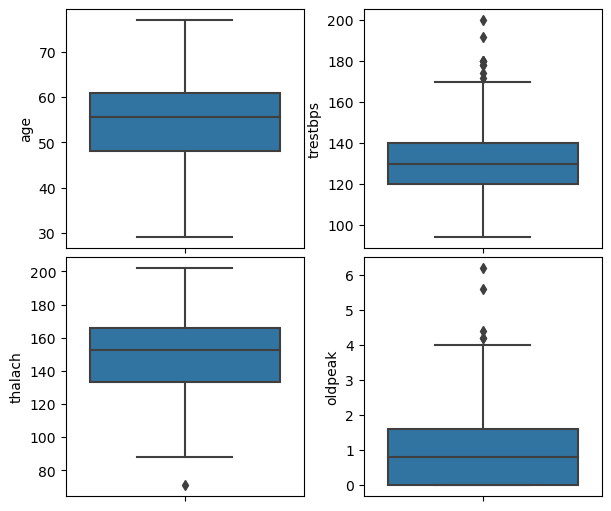

In [10]:
# Data Outliers
columns = ["age", "trestbps", "thalach", "oldpeak"]

fig, axes = plt.subplots(nrows=2, ncols = 2, figsize=(6, 5))

index  = 0
for col_no in range(0, 4, 2):
    sns.boxplot(data = df, y = columns[col_no], ax = axes[index][0])
    sns.boxplot(data = df, y = columns[col_no+1], ax = axes[index][1])
    index+= 1
plt.tight_layout(pad=0.3)
plt.show()

In [11]:
df = df[(np.abs(stats.zscore(df)) < 3).any(axis=1)]
df.shape

(302, 14)

In [12]:
# Splitting X and Y data
y = df["target"]
X = df.drop("target", axis = 1)

Skewness for the column is: age -0.2037432795959691
Distribution is left skewed.
Skewness for the column is: trestbps 0.7165414326647318
Distribution is right skewed.
Skewness for the column is: thalach -0.5326712468229611
Distribution is left skewed.
Skewness for the column is: oldpeak 1.2661727209102187
Distribution is right skewed.


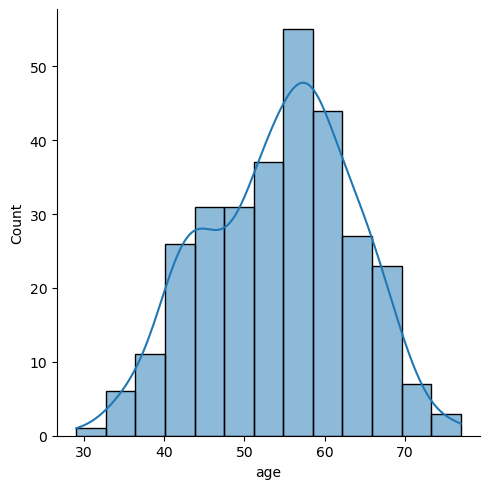

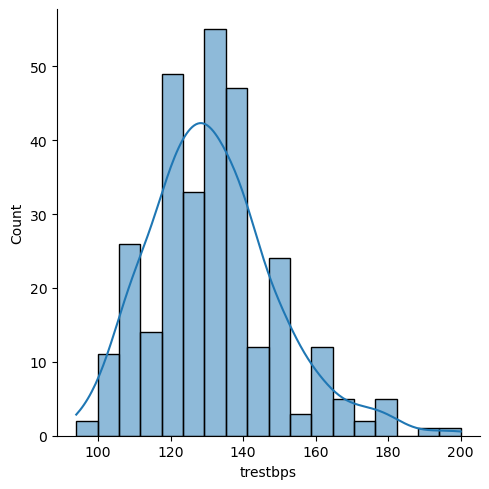

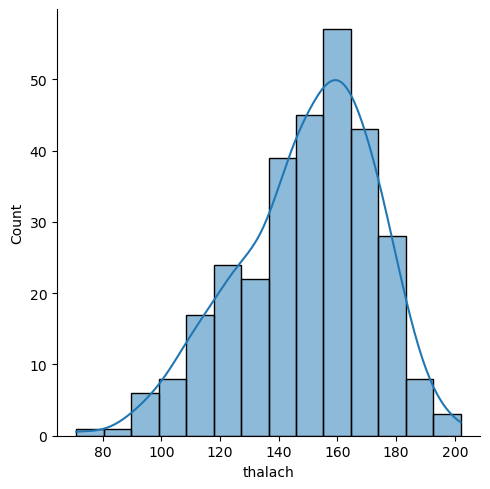

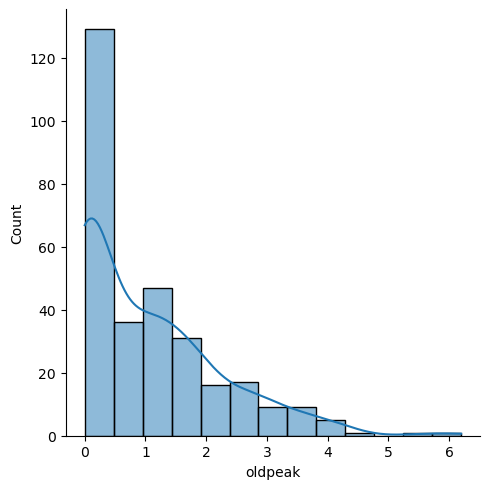

In [13]:
# Check data distribution (columns)
columns = ["age", "trestbps", "thalach", "oldpeak"]

check_distribution(X[columns])

In [14]:
# Cube root transformation to remove right skewness and cubic transformation to remove left skewness
for column in X[columns].columns:
    if X[column].skew() >= 0.5:
        print("Skewness before transformation: ",column, X[column].skew())
        print("Skewness after transformation: ",column, np.power(X[column], 0.33).skew())
        print()
        X[column] = np.power(X[column], 0.33)
    elif X[column].skew() <= 0.5:
        print("Skewness before transformation: ",column, X[column].skew())
        print("Skewness after transformation: ",column, np.power(X[column], 3).skew())
        print()
        X[column] = np.power(X[column], 3)

Skewness before transformation:  age -0.2037432795959691
Skewness after transformation:  age 0.5136583743335489

Skewness before transformation:  trestbps 0.7165414326647318
Skewness after transformation:  trestbps 0.4239206555864386

Skewness before transformation:  thalach -0.5326712468229611
Skewness after transformation:  thalach 0.18768700637183486

Skewness before transformation:  oldpeak 1.2661727209102187
Skewness after transformation:  oldpeak -0.2377663053911207



Skewness for the column is: age 0.5136583743335489
Distribution is right skewed.
Skewness for the column is: trestbps 0.4239206555864386
Distribution is right skewed.
Skewness for the column is: thalach 0.18768700637183486
Distribution is right skewed.
Skewness for the column is: oldpeak -0.2377663053911207
Distribution is left skewed.


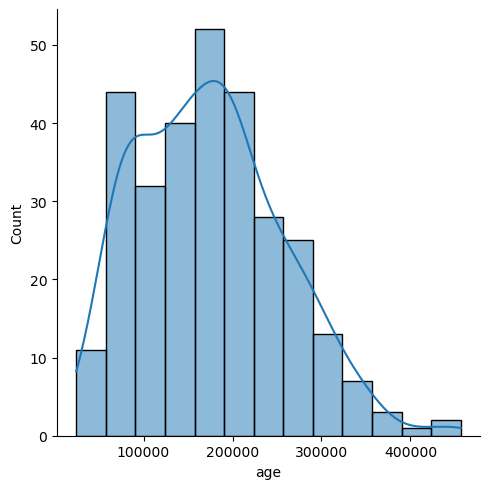

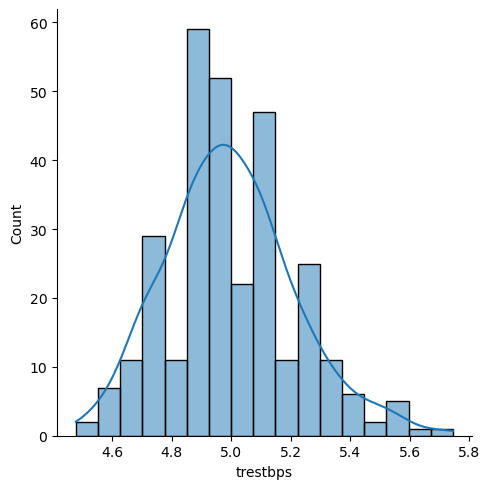

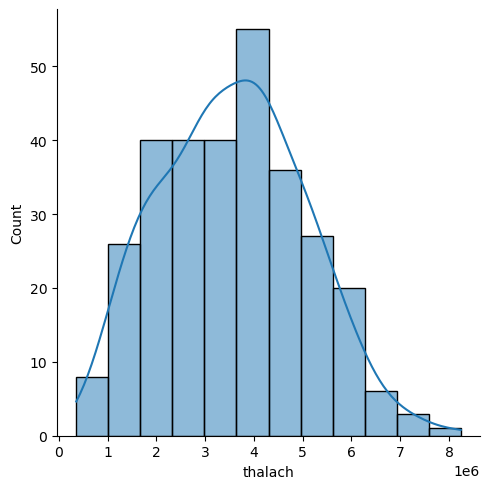

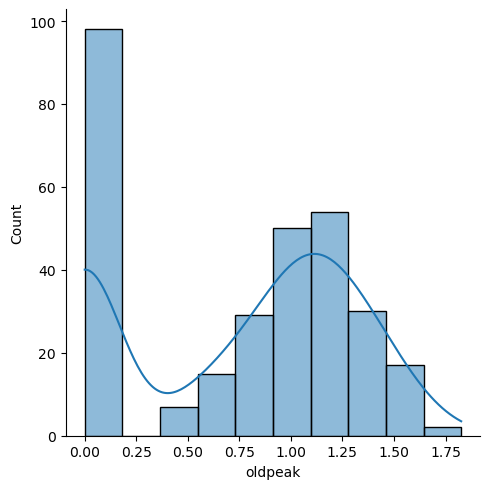

In [15]:
# Check distribution
check_distribution(X[columns])

In [16]:
# Scaling for features like Age, and thalach are high in comparision to others
# The features with higher magnitude would assume more importance
# Bring those features to the same scale

X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,250047,1,3,5.167154,233,1,0,3375000,0,1.316346,0,0,1
1,50653,1,2,4.984267,250,0,1,6539203,0,1.511967,0,0,2
2,68921,0,1,4.984267,204,0,0,5088448,0,1.117435,2,0,2
3,175616,1,1,4.854336,236,0,1,5639752,0,0.929009,2,0,2
4,185193,0,0,4.854336,354,0,1,4330747,1,0.844870,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,185193,0,0,5.107663,241,0,1,1860867,1,0.587949,1,0,3
299,91125,1,3,4.716932,264,0,1,2299968,0,1.062013,1,0,3
300,314432,1,0,5.155367,193,1,1,2803221,0,1.497573,1,2,3
301,185193,1,0,4.984267,131,0,1,1520875,1,1.062013,1,1,3


In [17]:
X = find_and_remove_correlated_features(X.copy(), 0.80)

A feature is correlated if they have a correlation of 0.8

Correlated features are:

No column is correlated enough with other column to be removed.


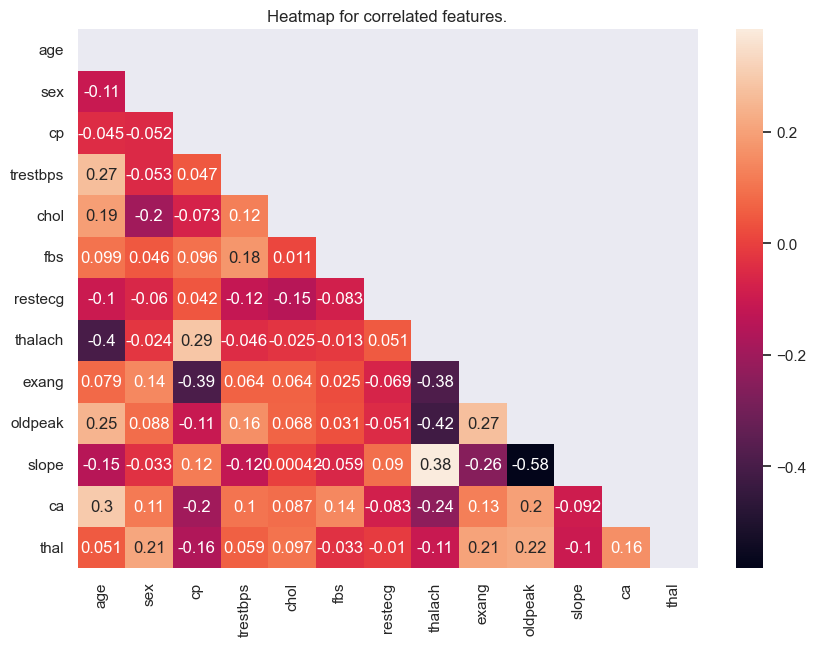

In [18]:
sns.set(rc={'figure.figsize':(10,7)});

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(X.corr())

# using the upper triangle matrix as mask 
sns.heatmap(X.corr(), annot=True, mask=matrix)
plt.title("Heatmap for correlated features.");

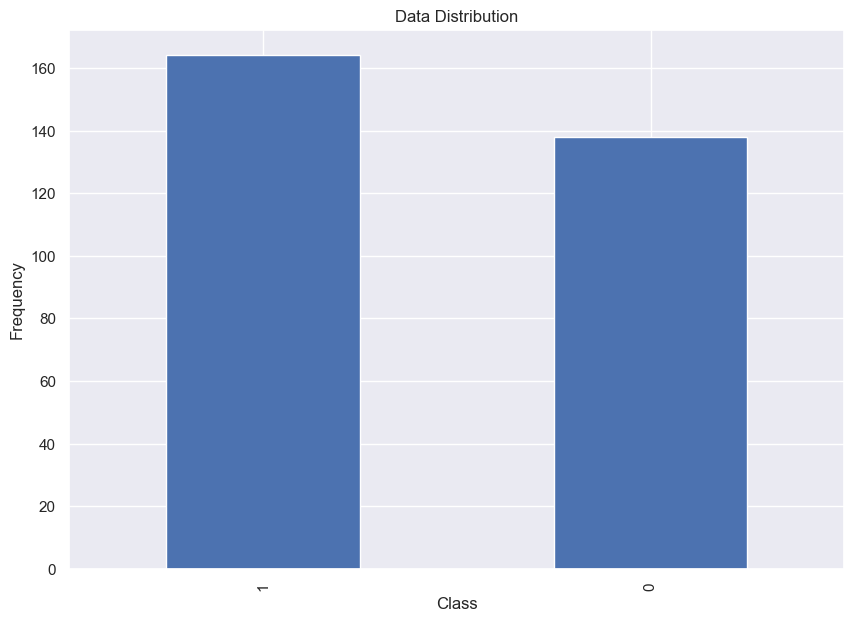

In [19]:
y.value_counts().plot(kind = "bar")
plt.title("Data Distribution");
plt.xlabel("Class");
plt.ylabel("Frequency");

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  1.0
Mean Accuracy on test set is:  0.7579781420765027

Mean F score on train set is: 1.0
Mean F score on test set is: 0.7742630092869994

Mean Precision on train set is: 0.7904512877251214
Mean Precision on test set is: 0.7904512877251214

Mean Recall on train set is: 1.0
Mean Recall on test set is: 0.7689393939393939

Mean Train ROC is: 1.0
Mean Test ROC is: 0.75748556998557
Mean Train loss is: -1.4566126083082051e-13
Mean Test loss is: 262.49470060132114
Total time taken: 0.31267476081848145


Weight,Feature
0.3060,cp
0.1682,ca
0.1368,thal
0.0960,chol
0.0889,oldpeak
0.0632,thalach
0.0535,age
0.0265,restecg
0.0214,slope
0.0184,trestbps


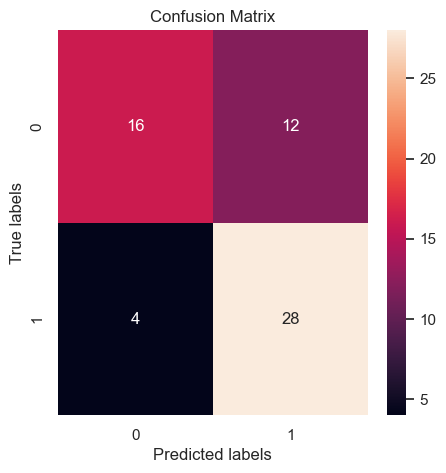

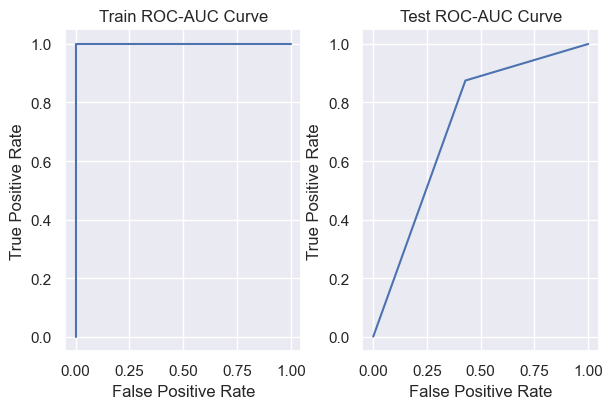

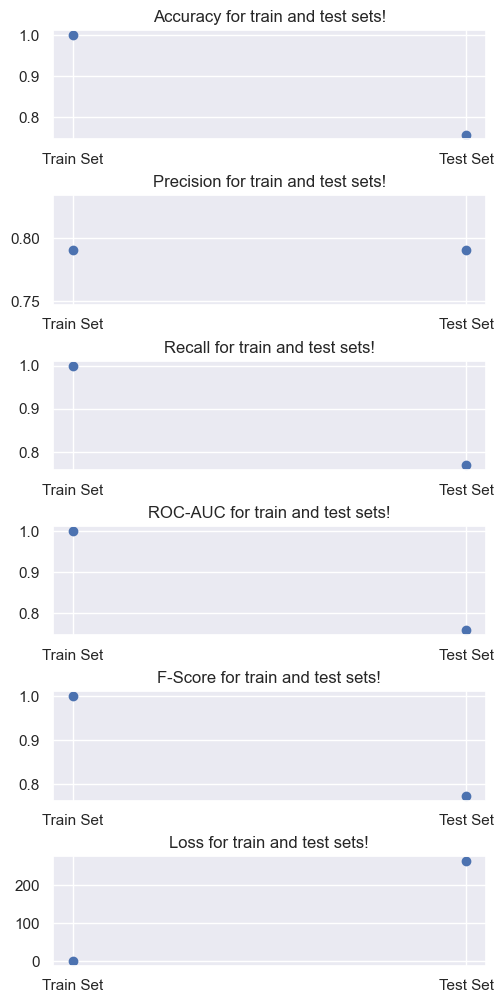

In [20]:
# Decision Tree
dt = classifier(DecisionTreeClassifier(random_state = 0), X, y)
eli5.show_weights(dt, feature_names= list(X.columns))

In [21]:
# Tuning the decision tree
dt_grid = { 'max_depth' : np.arange(1, 25)  }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

dt_opt = gridsearchit(dt, dt_grid, X_train, X_test, y_train, y_test)

Results from Grid Search: 

The best estimator across ALL searched params for DecisionTreeClassifier
 DecisionTreeClassifier(max_depth=3, random_state=0)

The best score across ALL searched params for DecisionTreeClassifier 0.8253676470588235

The best parameters across ALL searched params for DecisionTreeClassifier:
 {'max_depth': 3}



Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.8559218135554014
Mean Accuracy on test set is:  0.7978688524590163

Mean F score on train set is: 0.8627285790166968
Mean F score on test set is: 0.8217266042585507

Mean Precision on train set is: 0.7959431315427057
Mean Precision on test set is: 0.7959431315427057

Mean Recall on train set is: 0.9054823039555864
Mean Recall on test set is: 0.8539772727272726

Mean Train ROC is: 0.9164290872394207
Mean Test ROC is: 0.8455543781064614
Mean Train loss is: 428.2808272968923
Mean Test loss is: 165.7861266955713
Total time taken: 0.2974371910095215


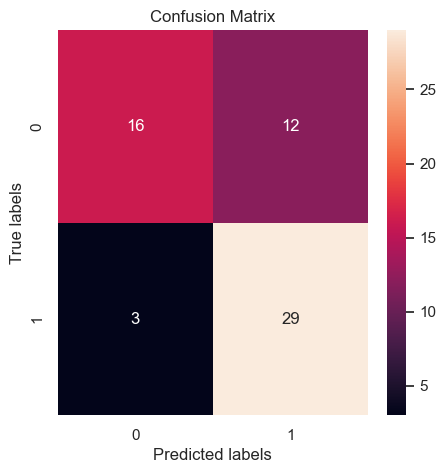

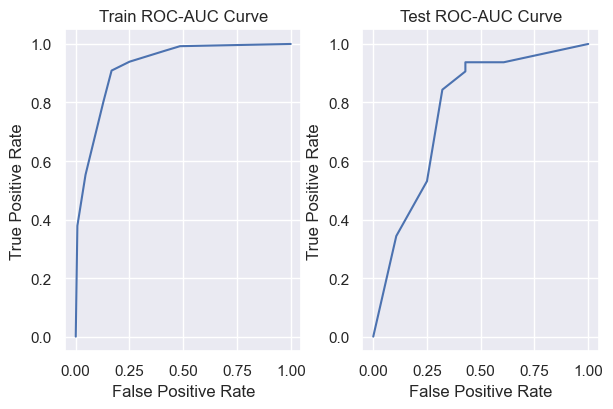

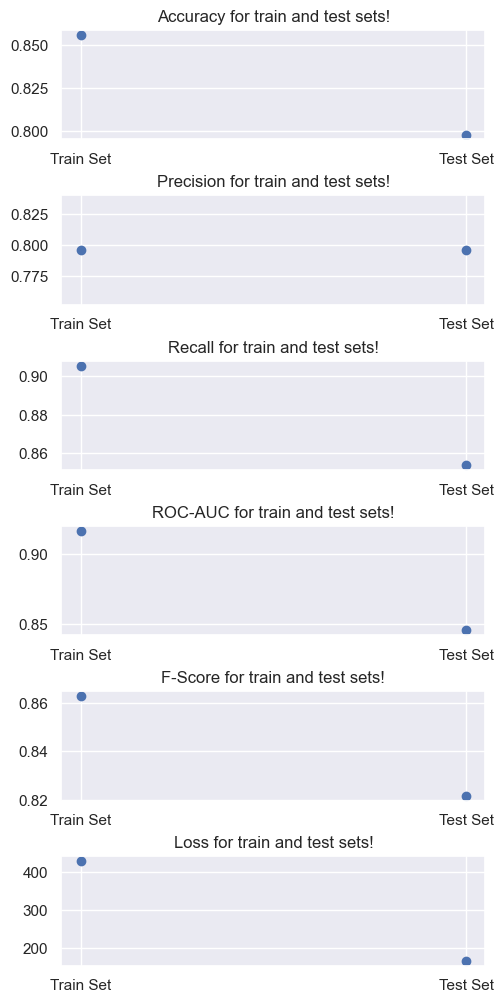

In [22]:
dt_opt = classifier(dt_opt, X, y)

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  1.0
Mean Accuracy on test set is:  0.8010928961748635

Mean F score on train set is: 1.0
Mean F score on test set is: 0.8161805581539954

Mean Precision on train set is: 0.8229603729603729
Mean Precision on test set is: 0.8229603729603729

Mean Recall on train set is: 1.0
Mean Recall on test set is: 0.8176136363636364

Mean Train ROC is: 1.0
Mean Test ROC is: 0.8893994508577843
Mean Train loss is: -1.4566126083082051e-13
Mean Test loss is: 207.2326583694641
Total time taken: 1.219465970993042


Weight,Feature
0.2844,cp
0.1803,thal
0.1087,ca
0.0717,oldpeak
0.0701,slope
0.0636,sex
0.0478,exang
0.0358,restecg
0.0310,trestbps
0.0280,fbs


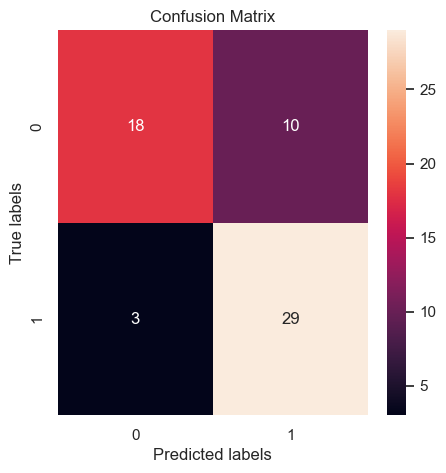

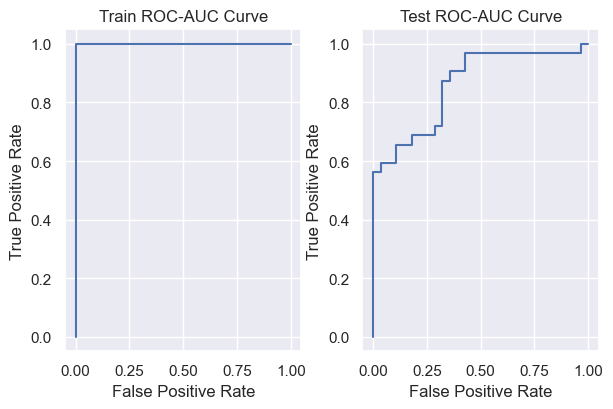

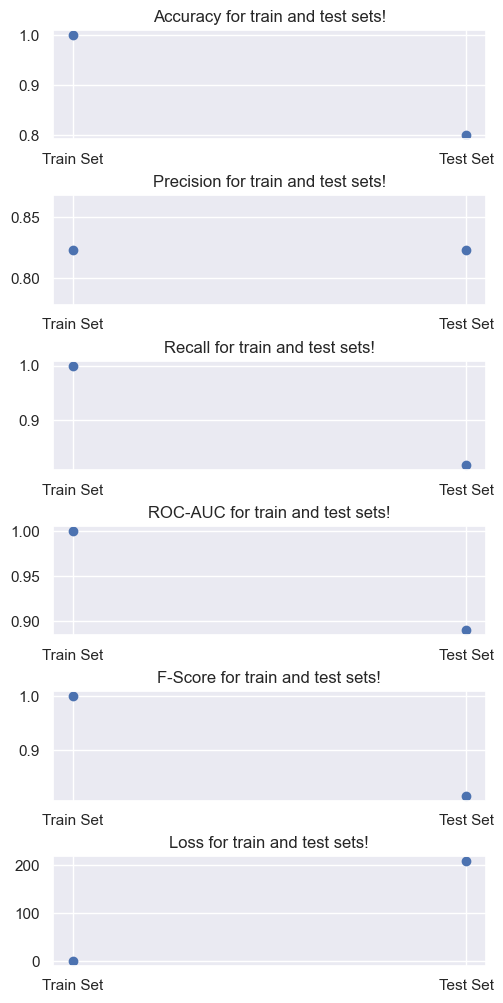

In [23]:
# Xgboost
xgb_clf = classifier(xgboost.XGBClassifier(random_state = 0), X, y)
eli5.show_weights(xgb_clf, feature_names= list(X.columns))

In [24]:
# Tuning Xgboost
xgb_grid = { 'max_depth': [5,6,7,8, 9],
                 'learning_rate' : [0.01,0.02,0.03],
                  'num_iterations'    : [100, 200, 500, 1000]
                 }

xgb_opt = gridsearchit(xgb_clf, xgb_grid, X_train, X_test, y_train, y_test)

[11:13:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Results from Grid Search: 

The best estimator across ALL searched params for XGBClassifier
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_iterations=100,
              num_parallel_t

[11:13:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  1  done
[11:13:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  2  done
[11:13:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  3  done
[11:13:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

Fold:  4  done
[11:13:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.



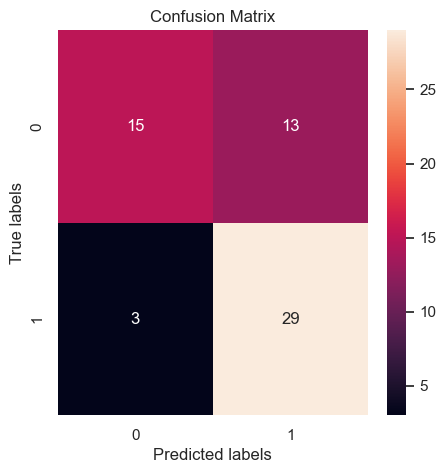

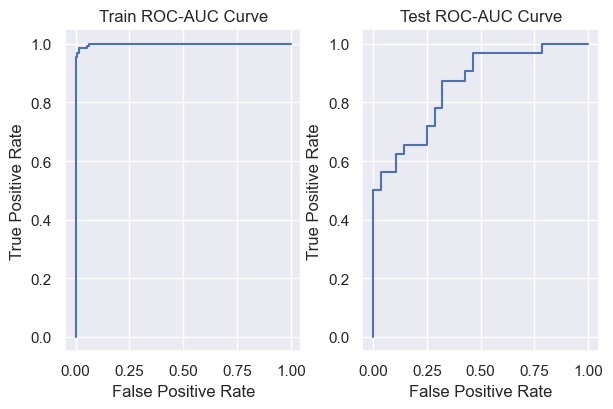

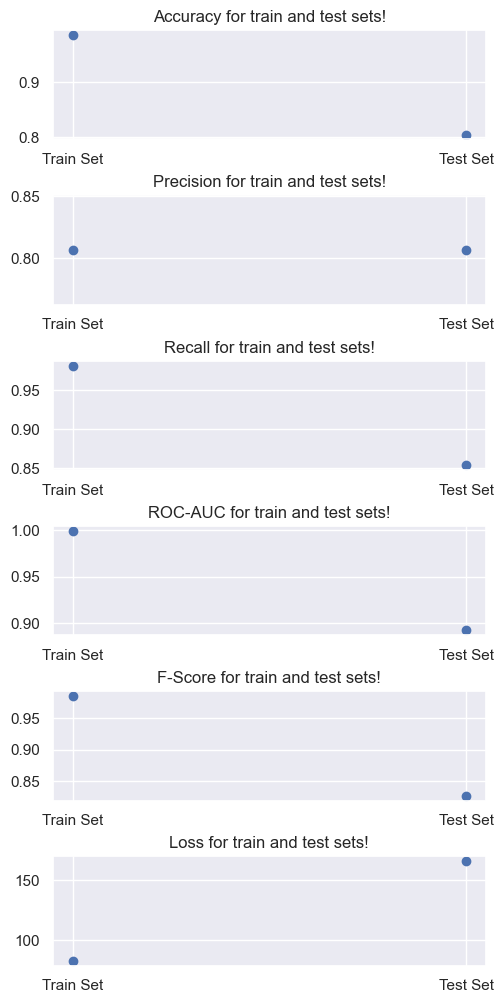

In [25]:
# Optimal Xgboost
xgb_opt = classifier(xgb_opt, X, y)

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.9184304880869766
Mean Accuracy on test set is:  0.8275956284153005

Mean F score on train set is: 0.9196196810121758
Mean F score on test set is: 0.8461261844828144

Mean Precision on train set is: 0.8328338562277118
Mean Precision on test set is: 0.8328338562277118

Mean Recall on train set is: 0.9329169558177192
Mean Recall on test set is: 0.8660984848484847

Mean Train ROC is: 0.9727277175235944
Mean Test ROC is: 0.8944429413179413
Mean Train loss is: 303.941232275214
Mean Test loss is: 151.970616137607
Total time taken: 0.5324978828430176


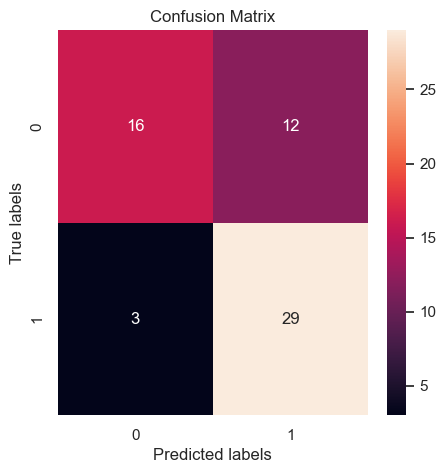

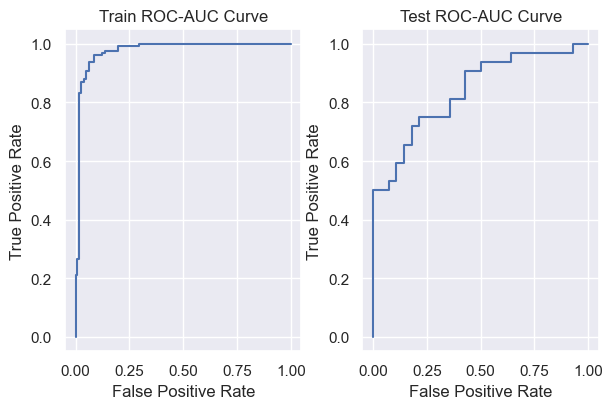

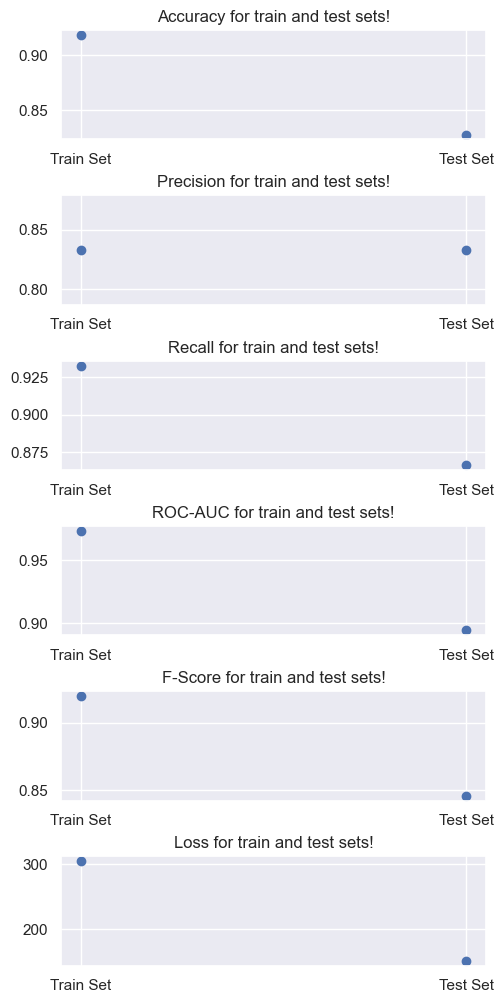

In [26]:
# SVM Classifier (Kernal = rbf)
svm_rbf = classifier(SVC(kernel = 'rbf', probability=True), X, y)
eli5.show_weights(svm_rbf, feature_names= list(X.columns))

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.8589636826278048
Mean Accuracy on test set is:  0.7945901639344262

Mean F score on train set is: 0.8637413083128622
Mean F score on test set is: 0.8130643878878597

Mean Precision on train set is: 0.807495744709367
Mean Precision on test set is: 0.807495744709367

Mean Recall on train set is: 0.8932916955817719
Mean Recall on test set is: 0.8234848484848485

Mean Train ROC is: 0.9241455094781348
Mean Test ROC is: 0.8966675685425685
Mean Train loss is: 483.54286952874935
Mean Test loss is: 200.32490309048197
Total time taken: 0.3504641056060791


Weight?,Feature
+0.751,cp
+0.463,thalach
+0.437,slope
+0.326,fbs
+0.247,restecg
+0.139,<BIAS>
+0.036,age
-0.214,chol
-0.286,exang
-0.309,oldpeak


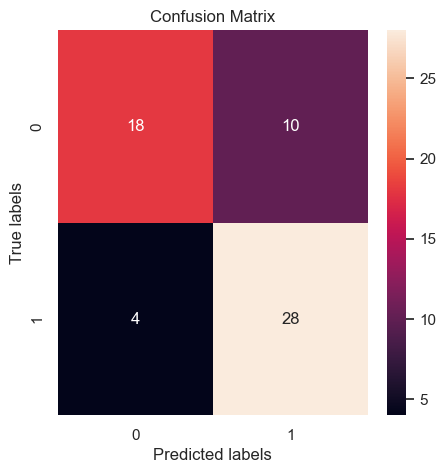

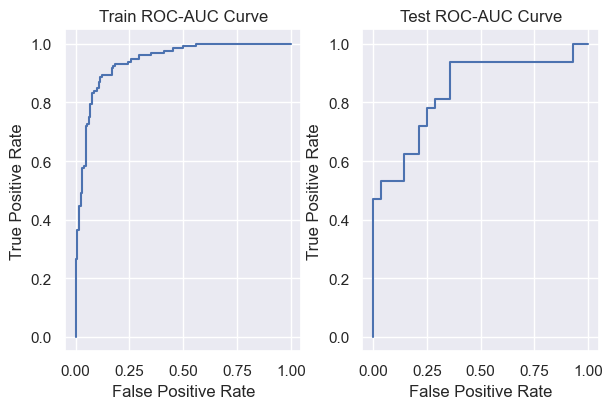

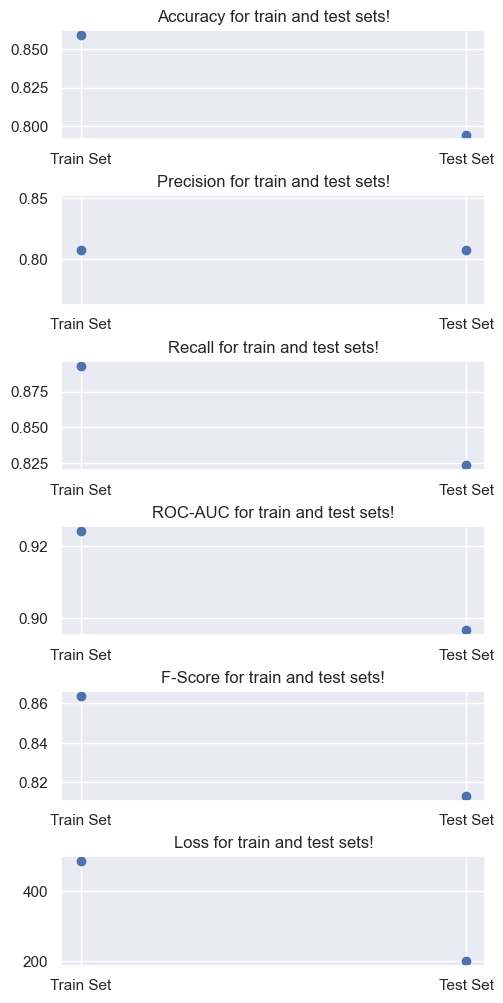

In [27]:
# Kernal = Linear
svm_linear = classifier(SVC(kernel = 'linear', probability=True), X, y)
eli5.show_weights(svm_linear, feature_names= list(X.columns))

/Users/honyaelfayoumy/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/honyaelfayoumy/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value Non

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.8948126301179737
Mean Accuracy on test set is:  0.7681420765027323

Mean F score on train set is: 0.8823846472274821
Mean F score on test set is: 0.760464281686097

Mean Precision on train set is: 0.8687578347578346
Mean Precision on test set is: 0.8687578347578346

Mean Recall on train set is: 0.7896252602359473
Mean Recall on test set is: 0.6768939393939394

Mean Train ROC is: 0.9812445280019417
Mean Test ROC is: 0.8369462231441398
Mean Train loss is: 953.2702284995343
Mean Test loss is: 366.11102978605317
Total time taken: 0.33379101753234863


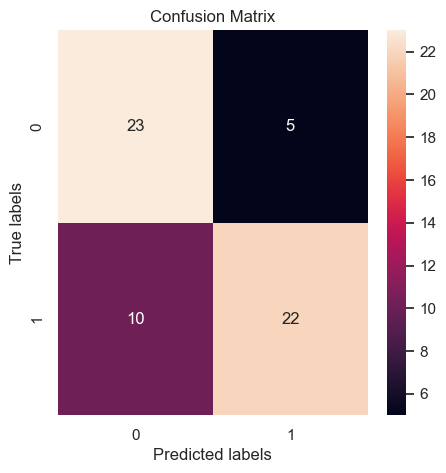

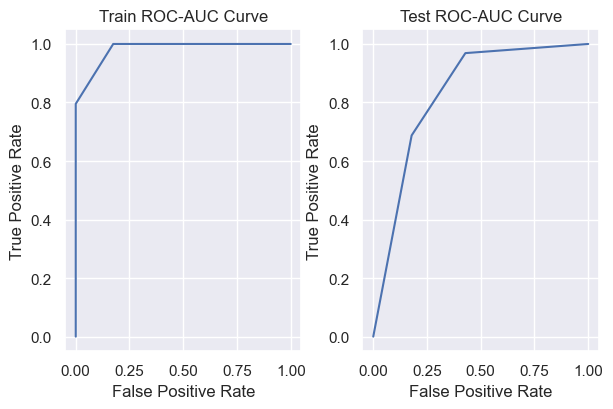

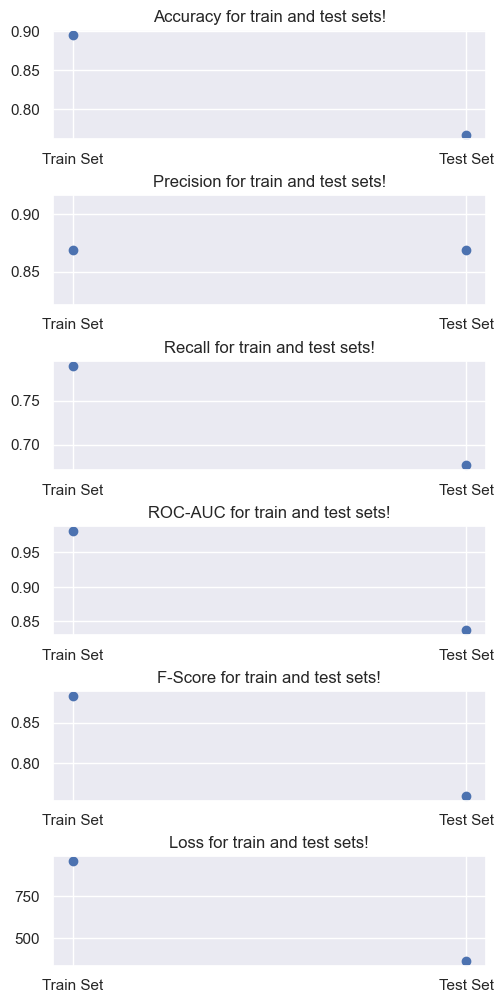

In [28]:
# KNN, 2 neighbors
kn2 = classifier(KNeighborsClassifier(n_neighbors = 2), X, y)

/Users/honyaelfayoumy/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/honyaelfayoumy/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value Non

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.8955759888965996
Mean Accuracy on test set is:  0.7979781420765027

Mean F score on train set is: 0.892806627057487
Mean F score on test set is: 0.8087426196944183

Mean Precision on train set is: 0.8349404761904763
Mean Precision on test set is: 0.8349404761904763

Mean Recall on train set is: 0.8704256303492943
Mean Recall on test set is: 0.7869318181818181

Mean Train ROC is: 0.9647383863212168
Mean Test ROC is: 0.8408656255010423
Mean Train loss is: 587.1591987134814
Mean Test loss is: 241.77143476437482
Total time taken: 0.3371269702911377


KNeighborsClassifier(n_neighbors=3)

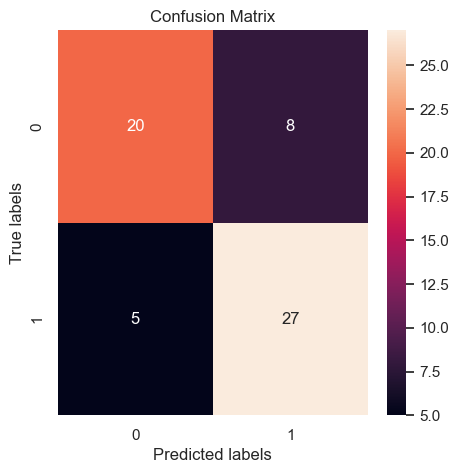

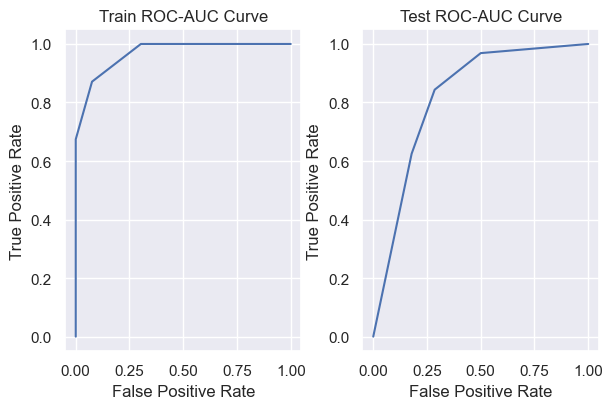

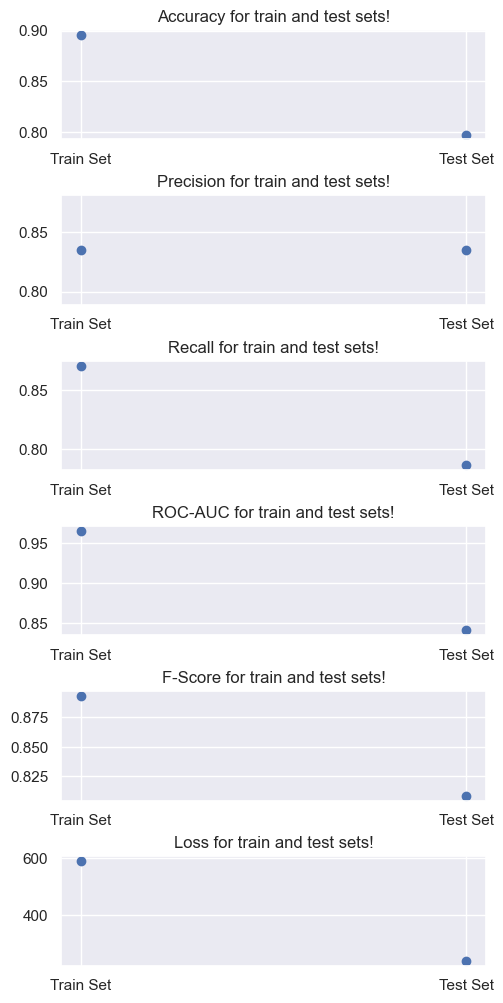

In [29]:
# Neighbors = 3
classifier(KNeighborsClassifier(n_neighbors = 3), X, y)

/Users/honyaelfayoumy/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/honyaelfayoumy/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value Non

Fold:  1  done
Fold:  2  done
Fold:  3  done
Fold:  4  done
Fold:  5  done

Mean Accuracy on train set is:  0.8765209345362017
Mean Accuracy on test set is:  0.7846448087431694

Mean F score on train set is: 0.8674387019385794
Mean F score on test set is: 0.7877812212794153

Mean Precision on train set is: 0.857054057054057
Mean Precision on test set is: 0.857054057054057

Mean Recall on train set is: 0.8079343048808697
Mean Recall on test set is: 0.7318181818181818

Mean Train ROC is: 0.960298898981284
Mean Test ROC is: 0.8575790143498476
Mean Train loss is: 870.3771651517487
Mean Test loss is: 303.941232275214
Total time taken: 0.4437739849090576


KNeighborsClassifier(n_neighbors=4)

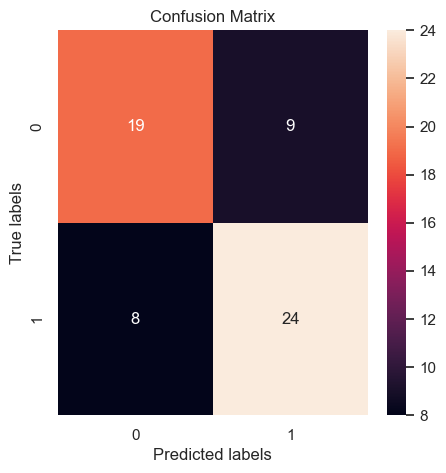

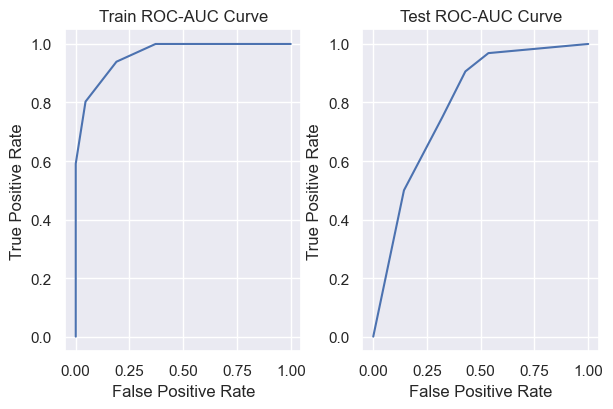

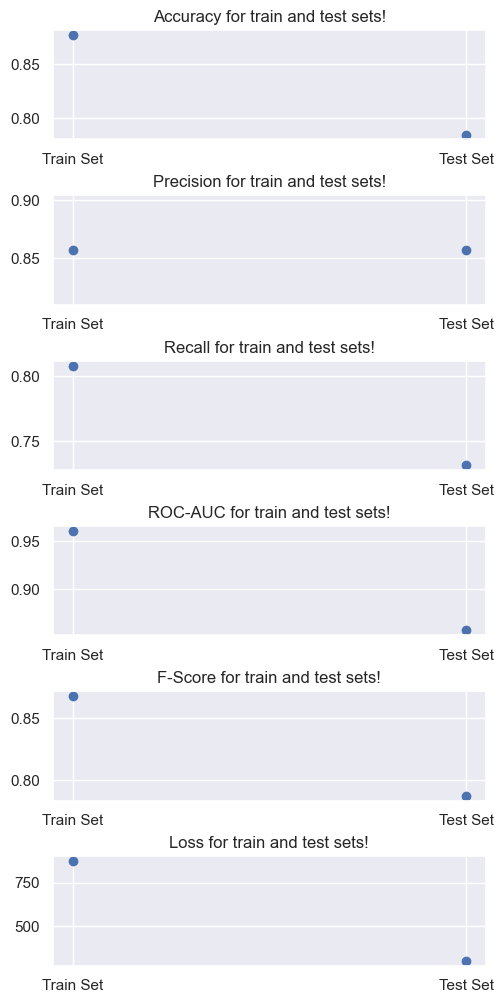

In [30]:
# Neighbors = 4
classifier(KNeighborsClassifier(n_neighbors = 4), X, y)

In [31]:
# Neural Networks
# Creating a model using Sequential in tensorflow
def sequential_model():
  seq_model = Sequential([
    Dense(150, kernel_initializer='normal', activation='relu'),
    Dropout(0.1),
    Dense(450, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='sigmoid')
  ])
  return seq_model

seq_model = sequential_model()
seq_model.compile(
    optimizer=Adam(learning_rate=0.01), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

start = time.time()
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = seq_model.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test), callbacks=Callback)
print(f'Time: {time.time() - start}')

Epoch 1/10


2023-02-12 11:16:51.310176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9/9 [==============================] - 1s 16ms/step - loss: 0.5103 - accuracy: 0.7463 - val_loss: 0.3972 - val_accuracy: 0.8525
Epoch 2/10
9/9 [==============================] - 0s 4ms/step - loss: 0.3392 - accuracy: 0.8676 - val_loss: 0.5270 - val_accuracy: 0.8689
Epoch 3/10
9/9 [==============================] - 0s 4ms/step - loss: 0.2726 - accuracy: 0.8824 - val_loss: 0.6287 - val_accuracy: 0.8852
Epoch 4/10
9/9 [==============================] - 0s 4ms/step - loss: 0.2567 - accuracy: 0.8934 - val_loss: 0.4944 - val_accuracy: 0.8033
Epoch 5/10
9/9 [==============================] - 0s 4ms/step - loss: 0.2888 - accuracy: 0.8456 - val_loss: 0.6839 - val_accuracy: 0.8197
Epoch 6/10
9/9 [==============================] - 0s 4ms/step - loss: 0.2472 - accuracy: 0.8787 - val_loss: 0.5286 - val_accuracy: 0.8033
Epoch 7/10
9/9 [==============================] - 0s 4ms/step - loss: 0.1963 - accuracy: 0.9228 - val_loss: 0.7697 - val_accuracy: 0.8361
Epoch 8/10
9/9 [============================

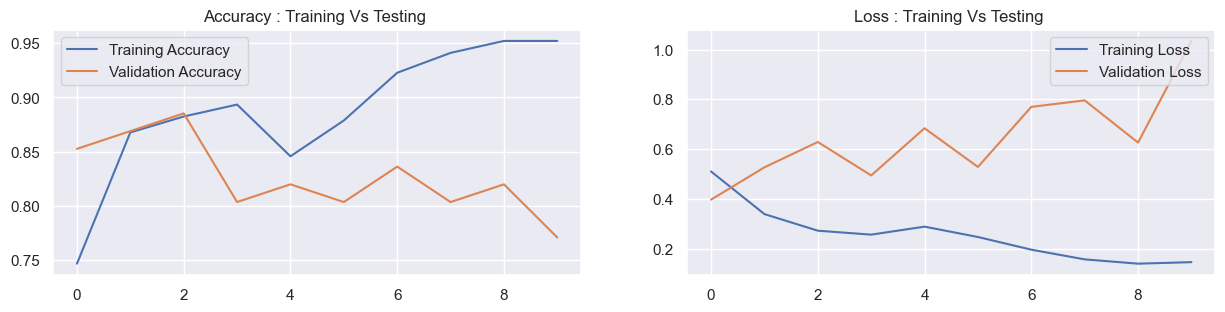

[11:13:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

[11:13:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

[11:13:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

[11:13:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

[11:13:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_iterations" } are not used.

[11:13:04] WARNING: /Users/runner/work/xgboost/xgboost/pytho

In [32]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']


plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Testing ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Testing ')
plt.legend(loc='upper right')
plt.show()